In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

<div class="alert alert-block alert-info">
DALAS TME 8 - Protocole d'evaluation en ML
</div>

# Train, val et test

<div class="alert alert-block alert-info">
Chargement et division des données : Separation des données en trois ensembles : entraînement (pour apprendre le modèle), validation (pour vérifier la progression de l'apprentissage) et test (pour l'évaluation finale et la comparaison avec d'autres modèles).
</div>

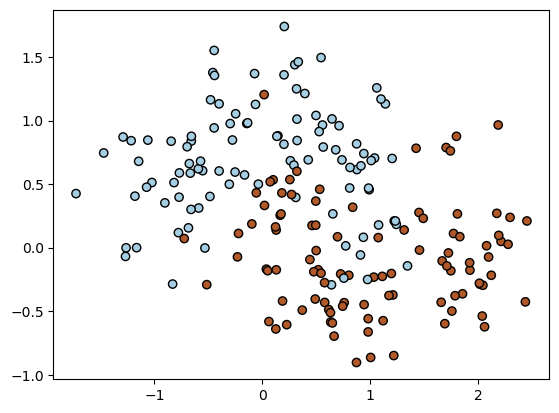

In [27]:
# Load the dataset
torch.manual_seed(42)
X, y = make_moons(n_samples=200, noise=0.3, random_state=42)
dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).view(-1, 1))

train_data, val_data, test_data = torch.utils.data.random_split(dataset, [0.6, 0.2, 0.2])

# Dataloaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Define the network
class BinaryClassifier(nn.Module):
    def __init__(self, hidden_size=256, activation=nn.ReLU()):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(2, hidden_size)  # 2 input features
        self.fc2 = nn.Linear(hidden_size, 1)
        self.activation = activation

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')

<div class="alert alert-block alert-info">
    Le code suivant sert a l'entrainement du modele, l'analyser rapitement et l'executer. Observez l'evolution de la loss au fil des epochs et de l'accuracy sur le teste de val. Qu'est ce qu'on observe?
</div>

100%|██████████| 2000/2000 [00:15<00:00, 133.29it/s]


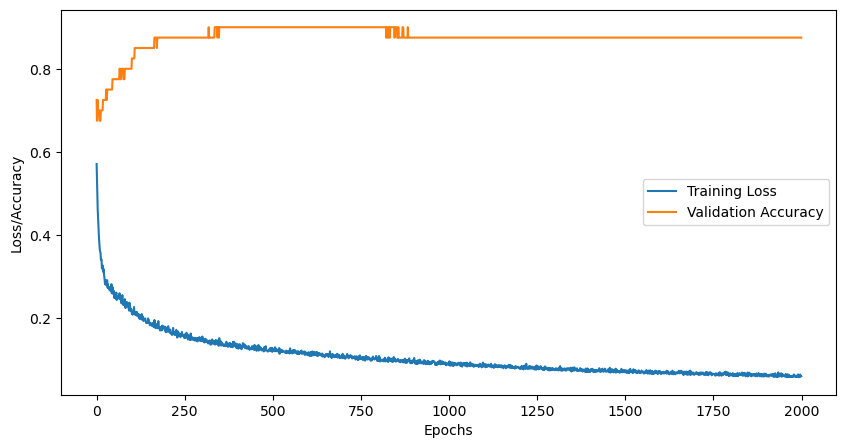

In [28]:
# Initialize the model, loss criterion, and optimizer
model = BinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists for tracking the training and validation losses and validation accuracy
train_losses = []
val_losses = []
val_accuracies = []

# Number of epochs to train the model
num_epochs = 2000

# Training and validation loop
for epoch in tqdm(range(num_epochs)):
    # Training phase
    model.train()  # Set the model to training mode
    total_train_loss = 0

    for data, labels in train_loader:
        optimizer.zero_grad()  # Clear gradients
        output = model(data)   # Forward pass
        loss = criterion(output, labels)  # Compute loss
        loss.backward()        # Backpropagate the loss
        optimizer.step()       # Update weights

        total_train_loss += loss.item()

    average_train_loss = total_train_loss / len(train_loader)
    train_losses.append(average_train_loss)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    total_correct = 0

    with torch.no_grad():  # Disable gradient computation
        for data, labels in val_loader:
            output = model(data)

            preds = torch.round(output)
            total_correct += preds.eq(labels.view_as(preds)).sum().item()

    accuracy = total_correct / len(val_data)
    val_accuracies.append(accuracy)

# Plotting the training results
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()


<div class="alert alert-block alert-info">
    Adapter le code antecedent afin de garder le modele qui a la meilleure accuracy en validation et celui qui a été entrainé le plus longtems (avec la loss plus petite).
</div>

100%|██████████| 2000/2000 [00:14<00:00, 140.11it/s]


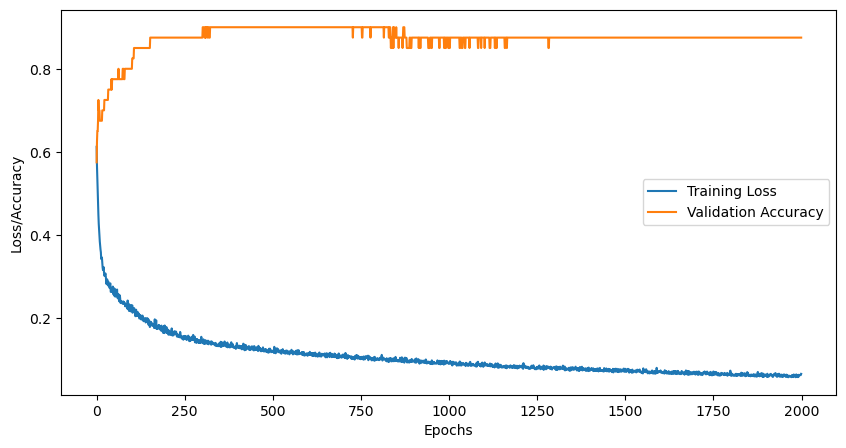

In [32]:
# Initialize the model, loss criterion, and optimizer
model = BinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists for tracking the training and validation losses and validation accuracy
train_losses = []
val_losses = []
val_accuracies = []

best_modelAccuracy = copy.deepcopy(model)
best_accuracy = 0

# Training and validation loop
for epoch in tqdm(range(num_epochs)):
    # Training phase
    model.train()  # Set the model to training mode
    total_train_loss = 0

    for data, labels in train_loader:
        optimizer.zero_grad()  # Clear gradients
        output = model(data)   # Forward pass
        loss = criterion(output, labels)  # Compute loss
        loss.backward()        # Backpropagate the loss
        optimizer.step()       # Update weights

        total_train_loss += loss.item()

    average_train_loss = total_train_loss / len(train_loader)
    train_losses.append(average_train_loss)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    total_correct = 0

    with torch.no_grad():  # Disable gradient computation
        for data, labels in val_loader:
            output = model(data)

            preds = torch.round(output)
            total_correct += preds.eq(labels.view_as(preds)).sum().item()

    accuracy = total_correct / len(val_data)
    val_accuracies.append(accuracy)

    # Save the model with the best accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_modelAccuracy = copy.deepcopy(model)

# Plotting the training results
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

<div class="alert alert-block alert-info">
Comparer l'exactitude (accuracy) sur les ensembles de validation et de test des deux modèles pour identifier le plus performant. Analyser également la courbe ROC pour effectuer cette comparaison. Que nous indique l'exactitude sur le jeu de test par rapport à celle sur le jeu de validation ? Quels éléments supplémentaires la courbe ROC nous permet-elle de comprendre ?
</div>

In [43]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_scores1, y_scores2, title):

    fpr1, tpr1, _ = roc_curve(y_true, y_scores1)
    roc_au1c = auc(fpr1, tpr1)

    fpr2, tpr2, _ = roc_curve(y_true, y_scores2)
    roc_au2c = auc(fpr2, tpr2)

    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.plot(fpr1, tpr1, label=f"Model with smallest loss (AUC = {roc_au1c:.3f})")
    plt.plot(fpr2, tpr2, label=f"Model with best accuracy (AUC = {roc_au2c:.3f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    # confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_confusion_matrix(y_true, y_pred, title, labels=['0', '1']):
    conf_mat = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_xlabel('Prédit')
    ax.set_ylabel('Vrai')
    ax.set_title('Matrice de confusion')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.show()

Test accuracy of the model with the smallest loss: 0.900
Test accuracy of the model with the best accuracy: 0.875
Validation accuracy of the model with the smallest loss: 0.875
Validation accuracy of the model with the best accuracy: 0.900
Confusion matrix of the model with the smallest loss:


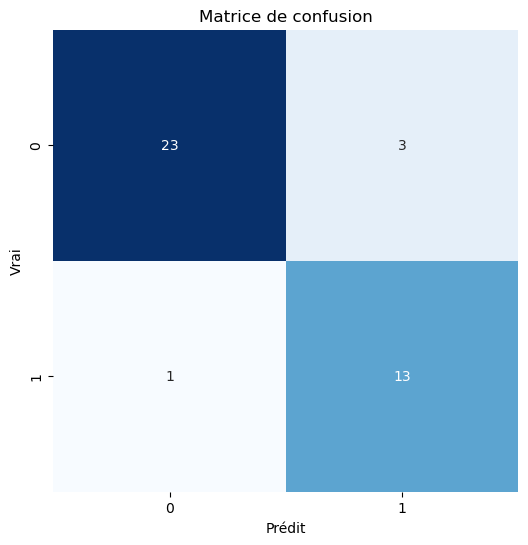

Confusion matrix of the model with the best accuracy:


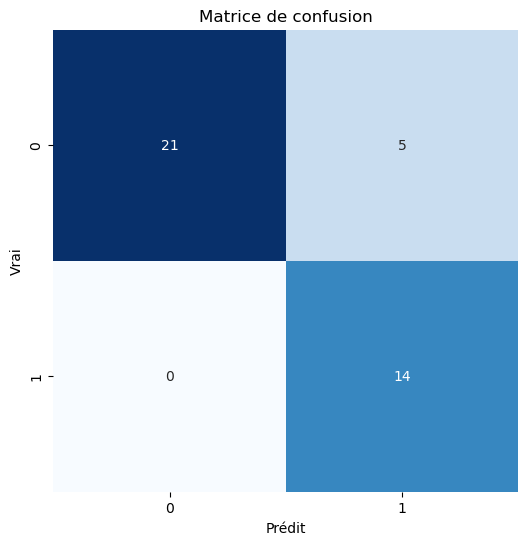

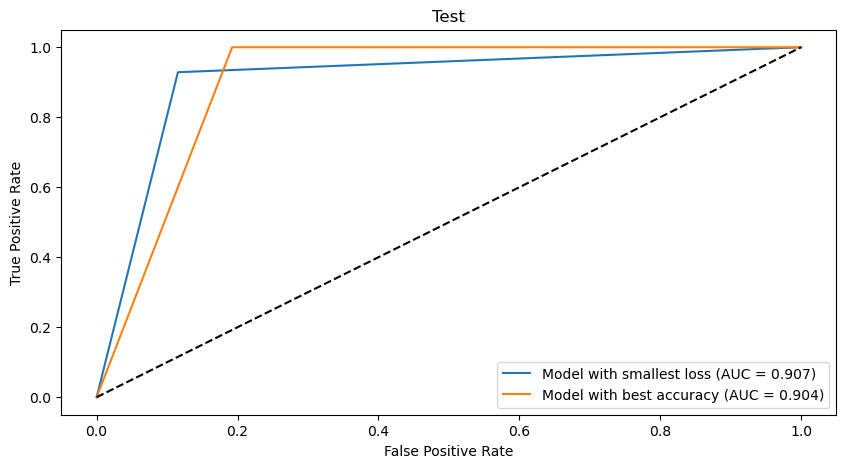

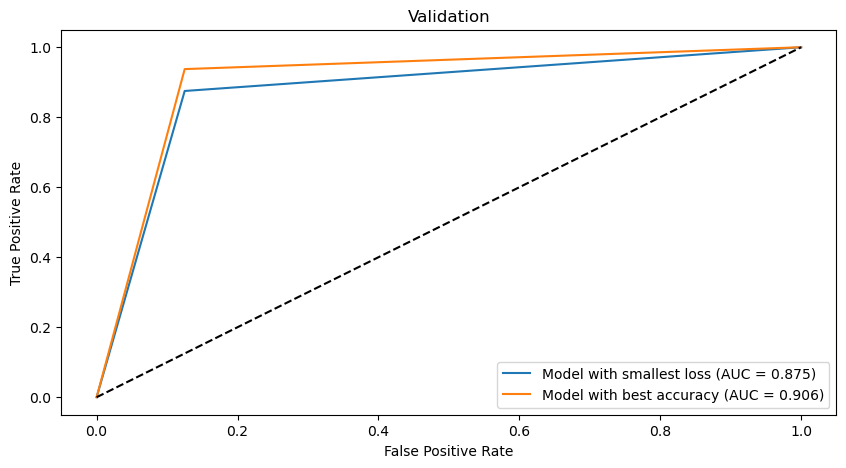

Confusion matrix of the model with the smallest loss:


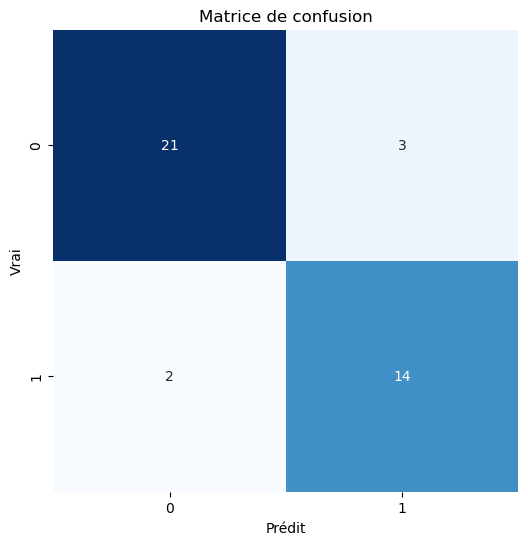

Confusion matrix of the model with the best accuracy:


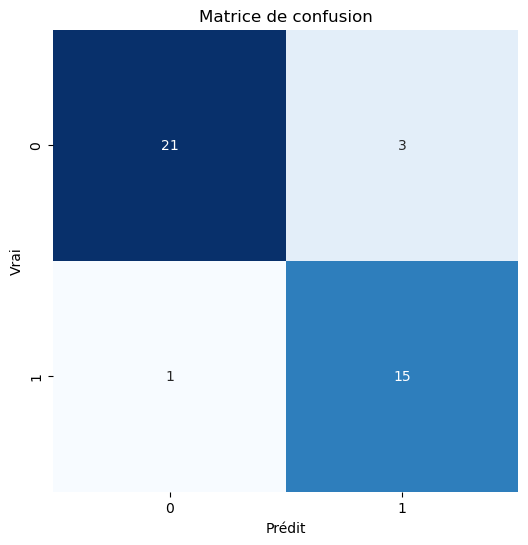

In [45]:
# comparaison entre les deux modèles sur le test et validation

def eval(data_loader, model1, model2):
    model1.eval()
    model2.eval()

    preds1_list = []
    preds2_list = []

    with torch.no_grad():
        total_correct1 = 0
        total_correct2 = 0

        for data, labels in data_loader:
            output1 = model1(data)
            output2 = model2(data)

            preds1 = torch.round(output1)
            preds2 = torch.round(output2)

            preds1_list.append(preds1)
            preds2_list.append(preds2)

            total_correct1 += preds1.eq(labels.view_as(preds1)).sum().item()
            total_correct2 += preds2.eq(labels.view_as(preds2)).sum().item()

        accuracy1 = total_correct1 / len(data_loader.dataset)
        accuracy2 = total_correct2 / len(data_loader.dataset)

    preds1_array = torch.cat(preds1_list).numpy()
    preds2_array = torch.cat(preds2_list).numpy()

    return accuracy1, accuracy2, preds1_array, preds2_array

test_accuracy, best_test_accuracy, test_preds1, test_preds2 = eval(test_loader,  model, best_modelAccuracy)
val_acc, best_val_acc, val_preds1, val_preds2 = eval(val_loader, model, best_modelAccuracy)

print(f"Test accuracy of the model with the smallest loss: {test_accuracy:.3f}")
print(f"Test accuracy of the model with the best accuracy: {best_test_accuracy:.3f}")
print(f"Validation accuracy of the model with the smallest loss: {val_acc:.3f}")
print(f"Validation accuracy of the model with the best accuracy: {best_val_acc:.3f}")


true_label_val = []
true_label_test = []

for _, labels in test_data:
    true_label_test.append(labels)

for _, labels in val_data:
    true_label_val.append(labels)


true_label_val = torch.cat(true_label_val).numpy()
true_label_test = torch.cat(true_label_test).numpy()

print("Confusion matrix of the model with the smallest loss:")
plot_confusion_matrix(true_label_test, test_preds1, "Test")
print("Confusion matrix of the model with the best accuracy:")
plot_confusion_matrix(true_label_test, test_preds2, "Test")




# Analyse Courbe ROC
plot_roc_curve(y_true=true_label_test, y_scores1= test_preds1,
               y_scores2= test_preds2,
               title="Test")
plot_roc_curve(y_true=true_label_val, y_scores1= val_preds1,
                y_scores2= val_preds2,
                title="Validation")

print("Confusion matrix of the model with the smallest loss:")
plot_confusion_matrix(true_label_val, val_preds1, "Validation")
print("Confusion matrix of the model with the best accuracy:")
plot_confusion_matrix(true_label_val, val_preds2, "Validation")

<div class="alert alert-block alert-info">
Afficher la frontière de décision des deux modèles. Comme nous sommes dans un cas 2D, c'est facile à analyser. Cela confirme-t-il les déductions obtenues précédemment ? Quel phénomène observe-t-on en particulier ?
</div>

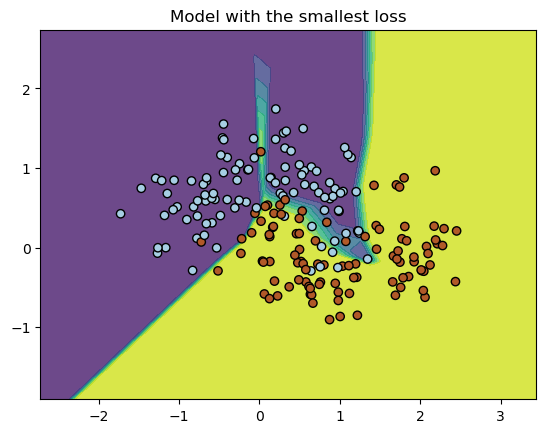

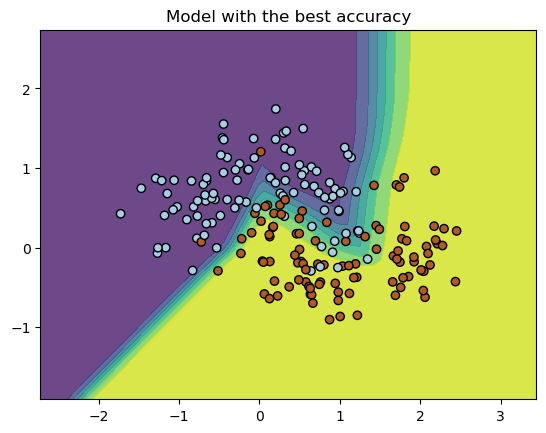

In [47]:
def plot_decision_boundary(model, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    Z = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)).detach().numpy()
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')
    plt.title(title)
    plt.show() 

plot_decision_boundary(model, "Model with the smallest loss")
plot_decision_boundary(best_modelAccuracy, "Model with the best accuracy")

<div class="alert alert-block alert-info">
Ce problème d'overfitting est-il dû à l'architecture du réseau de neurones ou aux paramètres ? Effectuer une recherche exhaustive (grid search) sur la taille de la couche cachée et analyser le modèle qui présente les meilleurs scores issus du grid search.
</div>

In [54]:
def create_model(hidden_size):
    model = BinaryClassifier(hidden_size=hidden_size)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    return model, criterion, optimizer

num_epochs = 2000
best_model_hidden = None
best_model = None

best_accuracy = 0

for hidden_size in [32, 64, 128, 256, 512]:
    model, criterion, optimizer = create_model(hidden_size)
    train_losses = []
    val_losses = []
    val_accuracies = []

    best_accuracy_hidden = 0
    for epoch in range(num_epochs):

        model.train()
        total_train_loss = 0
        
        for data, labels in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        average_train_loss = total_train_loss / len(train_loader)
        train_losses.append(average_train_loss)

        model.eval()
        total_correct = 0

        with torch.no_grad():
            for data, labels in val_loader:
                output = model(data)

                preds = torch.round(output)
                total_correct += preds.eq(labels.view_as(preds)).sum().item()

        accuracy = total_correct / len(val_data)
        val_accuracies.append(accuracy)
        
        if best_accuracy_hidden < accuracy:
            best_accuracy_hidden = accuracy
            best_model_hidden = copy.deepcopy(model)

    if best_accuracy_hidden > best_accuracy:
        best_accuracy = best_accuracy_hidden
        best_model = copy.deepcopy(best_model_hidden)

    print(f"Hidden size: {hidden_size}, Validation accuracy: {best_accuracy_hidden:.3f}")

Hidden size: 32, Validation accuracy: 0.900
Hidden size: 64, Validation accuracy: 0.900
Hidden size: 128, Validation accuracy: 0.900
Hidden size: 256, Validation accuracy: 0.900
Hidden size: 512, Validation accuracy: 0.900


# Regression et données hors distribution

<div class="alert alert-block alert-info">
Nous allons analyser les capacités de généralisation d'un réseau de neurones simple sur des données hors distribution. Pour ce faire, nous prenons des points correspondant à une sinusoïde pour l'entraînement dans l'intervalle \([0, 2\pi]\) et nous allons tester sur l'intervalle \([- \pi, 3\pi]\).
</div>

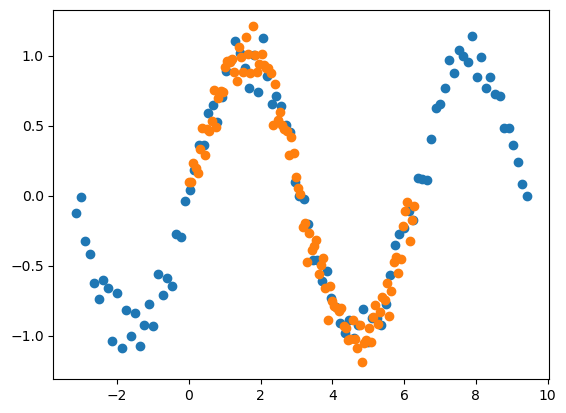

In [55]:
X_train = torch.linspace(0, 2 * torch.pi, 100) 
X_train = torch.linspace(0, 2 * torch.pi, 100) 
y_train = torch.sin(X_train) + torch.randn(100) * 0.1

X_test = torch.linspace(-1 * torch.pi, 3 * torch.pi, 100) 
y_test = torch.sin(X_test)+ torch.randn(100) * 0.1

plt.scatter(X_test, y_test, label='Out of Distribution (Test)')
plt.scatter(X_train, y_train, label='In Distribution (Train)')

<div class="alert alert-block alert-info">
Créer deux modèles, l'un utilisant ReLU pour l'activation et l'autre utilisant tanh. De plus, définir une fonction evaluate, qui prend en paramètre les prédictions et les vrais labels et retourne la MSE (Mean Squared Error), MAE (Mean Absolute Error), MAPE (Mean Absolute Percentage Error), MSLE (Mean Squared Logarithmic Error) et R2 (coefficient de détermination).
</div>

In [58]:
class SinusoideRegressor(nn.Module):
    def __init__(self, activation=nn.Tanh()):
        super(SinusoideRegressor, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 1)
        self.activation = activation

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

model1 = SinusoideRegressor(nn.Tanh())
model2 = SinusoideRegressor(nn.ReLU())

def evaluate(pred, target):
    mse = nn.MSELoss()(pred, target).item()
    mae = nn.L1Loss()(pred, target).item()
    mape = torch.mean(torch.abs((target - pred) / target)).item()
    msle = nn.MSELoss()(torch.log(pred + 1), torch.log(target + 1)).item()
    r2 = 1 - mse / torch.var(target).item()

    return mse, mae, mape, msle, r2



<div class="alert alert-block alert-info">
En utilisant le code fourni, apprenez les deux modèles.
</div>

In [59]:

class SinusoideRegressor(nn.Module):
    def __init__(self, activation=nn.Tanh()):
        super(SinusoideRegressor, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 1)
        self.activation = activation

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x


def train(model, num_epochs):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for _ in tqdm(range(num_epochs)):
        model.train()

        for i in range(len(X_train)):
            optimizer.zero_grad()
            x = torch.tensor([[X_train[i]]], dtype=torch.float32)
            y = torch.tensor([[y_train[i]]], dtype=torch.float32)

            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

    return model

trained_model = []
for model in [model1, model2]:
    model.eval()
    trained_model.append(train(model, 1000))

100%|██████████| 1000/1000 [01:27<00:00, 11.38it/s]


In [63]:
trained_model[0](X_test)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x100 and 1x64)


<div class="alert alert-block alert-info">
Filtrer les données de test en ne conservant que les exemples qui appartiennent à la distribution d'apprentissage. En utilisant la fonction "evaluate", calculer les scores pour les deux modèles pour le jeu de données d'entraînement filtré et celui complet. Quel modèle est meilleur pour les données dans la distribution et lequel généralise mieux pour des données hors distribution ?
</div>

In [61]:
# Filtrer les données de test en ne conservant que les exemples qui appartiennent à la distribution d'apprentissage
# Assuming X_test and y_test are numpy arrays
indices = np.where((0 <= X_test) & (X_test <= 2 * np.pi))

X_test_filtered = X_test[indices]
y_test_filtered = y_test[indices]

# Pseudo-code
score_filtered_model1 = evaluate(trained_model[0](X_test_filtered), y_test_filtered)
score_filtered_model2 = evaluate(trained_model[1](X_test_filtered), y_test_filtered)

score_full_model1 = evaluate(trained_model[0](X_test), y_test)
score_full_model2 = evaluate(trained_model[1](X_test), y_test)

# Pseudo-code
if score_filtered_model1[0] > score_filtered_model2[0]:
    print("Model 1 is better for in-distribution data.")
else:
    print("Model 2 is better for in-distribution data.")

if score_full_model1[0] > score_full_model2[0]:
    print("Model 1 generalizes better for out-of-distribution data.")
else:
    print("Model 2 generalizes better for out-of-distribution data.")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x50 and 1x64)


<div class="alert alert-block alert-info">
Afficher la sinusoide reelle correspondant a l'intervalle de test, puis afficher les predictions des deux modeles pour cet intervalle. Qu'est ce qu'on observe? Est ce qu'on retrouve les resultats observes avec les metriques?
</div>

ValueError: x and y must be the same size

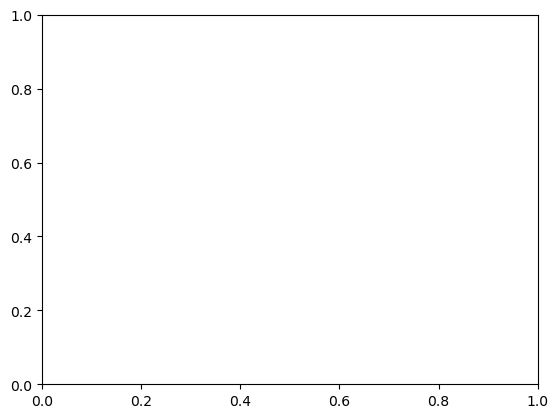

In [70]:
plt.scatter(X_test, y_test_filtered, label='Out of Distribution (Test)')

<div class="alert alert-block alert-info">
Bonus : Apprendre les modèles sur des variations du dataset d'entraînement, en faisant varier l'intervalle, la fréquence, l'amplitude, le bruit et le nombre de points. Faire des observations sur les performances des deux modèles et, en agrégeant les résultats, réaliser un test statistique.
</div>